In [1]:
from spacepy import pycdf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
from mpl_toolkits.mplot3d import axes3d
import matplotlib
import matplotlib.colors as colors
from collections import Counter
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import math
from lmfit.models import GaussianModel
from sklearn import mixture
from matplotlib.colors import LogNorm
from sklearn import cluster
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

In [59]:
npzfile = np.load('2002.npz')

start_dc = npzfile['arr_0']
end_dc = npzfile['arr_1']
start_c = npzfile['arr_2']
end_c = npzfile['arr_3']

date2 = pd.Timestamp.date(start_dc[len(start_dc)-1])
FGMfile = np.load(str(date2.year)+'_FGM.npz')
strahl_file = np.load(str(date2.year)+'_strahl.npz')

B_dir = FGMfile['arr_0']
#print(np.shape(B_dir))

all_strahl_width_0 = strahl_file['arr_0']
all_strahl_width_180 = strahl_file['arr_1']

pre_all_bp = []

for y in range(0,len(start_dc)):

    event = y
    #print(event)

    time = pd.Timestamp.time(start_dc[event])
    date = pd.Timestamp.date(start_dc[event])
    time1 = pd.Timestamp.time(end_dc[event])
    date1 = pd.Timestamp.date(end_dc[event])

    array = (date.year,date.month,date.day,time.hour,time.minute,time.second)
    array1 = (date1.year,date1.month,date1.day,time1.hour,time1.minute,time1.second)

    strs = ["" for x in range(6)]
    strs1 = ["" for x in range(6)]

    for i in range(len(array)):
        if array[i]<10:
            strs[i]='0'+str(array[i])
        else:
            strs[i]=str(array[i])
        if array1[i]<10:
            strs1[i]='0'+str(array1[i])
        else:
            strs1[i]=str(array1[i])

    stamp = strs[0]+strs[1]+strs[2]+'_'+strs[3]+strs[4]+strs[5]+'_'+strs1[0]+strs1[1]+strs1[2]+'_'+strs1[3]+strs1[4]+strs1[5]

    choose_file = '/Users/mayur/PhD/Cluster_data/Statistical_Study/PSD/PSD_DC/C2_CP_PEA_PITCH_SPIN_PSD__'+stamp+'_V170617.cdf'

    #print(choose_file)

    cdf = pycdf.CDF(choose_file)
    #for (i, item) in enumerate(cdf, start=0):
    #    print(i, item, cdf[i])
    
    epoch = cdf[0][...]

    #data_raw = cdf[26][...] #DEFlux
    data = cdf[26][...] #PSD
    
    energy = cdf[20][...]
    
    if len(energy) < 45:
        print(' ')
        pre_all_bp.append(0)
        continue
    
    if energy[0,0] < 0:
        print(' ')
        pre_all_bp.append(0)
        continue
    
    ### Only reshape data for DEFlux, not PSD 
    #data = []
        
    #for f in range(len(epoch)):
    #    a = data_raw[f].flatten()
    #    b = a.reshape(44,12,order='F')
    #    c = b.flatten()
    #    d = c.reshape(12,44)
    #    data.append(d)
    
    #data = np.array(data)
    
    pa = cdf[23][...]

    #print(energy[0,0:30])

    #ba = np.asscalar(np.where(energy[0]==173.09)[0]) #start of energy range bp analysis
    ba = np.asscalar(np.where(energy[0]==273.)[0]) #start of energy range bp analysis
    bb = np.asscalar(np.where(energy[0]==15.779)[0]) #end of energy range bp analysis
    sh = np.asscalar(np.where(energy[0]==534.17)[0]) #start of energy range suprathermal
    cs = np.asscalar(np.where(energy[0]==24.348)[0]) #end of energy range suprathermal
    
    
    bp_fluxes = []
    all_energies = []
        
    #if all_strahl_width_180[event] < 7.5: #### if strahl width at the parallel pa we're looking at < 7.5 then halo
    #    print(' ')
    #    pre_all_bp.append(0)
    #    continue

    for i in range(0,len(epoch)):
        for j in range(ba,bb):
            flux = data[i,3:9,j]
        
            e = energy[0,j]
            all_energies.append(e)
        
            flux[flux == -1.] = 0.
       
            bp_fluxes.append(flux)

    #bp_fluxes = StandardScaler().fit_transform(bp_fluxes)
    #print(np.shape(bp_fluxes))
    
    n_clusters = 6
    
    bp = []
    k_means = cluster.KMeans(n_clusters)
    all_cluster_s = k_means.fit(bp_fluxes)
    
    all_cluster_s.labels_[all_cluster_s.labels_ == 2] = 1
    all_cluster_s.labels_[all_cluster_s.labels_ == 3] = 1
    all_cluster_s.labels_[all_cluster_s.labels_ == 4] = 1
    all_cluster_s.labels_[all_cluster_s.labels_ == 5] = 1

    for (i, item) in enumerate(all_cluster_s.labels_, start=0):
        if all_cluster_s.labels_[i]>all_cluster_s.labels_[i-1]:
            bp.append(all_energies[i-1])

    bp = np.array(bp)
    

                
    while np.mean(bp) < 22:
        bp = []
        k_means = cluster.KMeans(n_clusters)
        all_cluster_s = k_means.fit(bp_fluxes)
    
        all_cluster_s.labels_[all_cluster_s.labels_ == 2] = 1
        all_cluster_s.labels_[all_cluster_s.labels_ == 3] = 1
        all_cluster_s.labels_[all_cluster_s.labels_ == 4] = 1

        for (i, item) in enumerate(all_cluster_s.labels_, start=0):
            if all_cluster_s.labels_[i]>all_cluster_s.labels_[i-1]:
                bp.append(all_energies[i-1])
                
    while np.mean(bp) > 220:
        bp = []
        k_means = cluster.KMeans(n_clusters)
        all_cluster_s = k_means.fit(bp_fluxes)
    
        all_cluster_s.labels_[all_cluster_s.labels_ == 2] = 1
        all_cluster_s.labels_[all_cluster_s.labels_ == 3] = 1
        all_cluster_s.labels_[all_cluster_s.labels_ == 4] = 1

        for (i, item) in enumerate(all_cluster_s.labels_, start=0):
            if all_cluster_s.labels_[i]>all_cluster_s.labels_[i-1]:
                bp.append(all_energies[i-1])
    
    print(event,np.median(bp))
    pre_all_bp.append(np.median(bp))

 
 
 
 
 
5 47.865
6 56.717
7 56.717
8 56.717
9 37.66
10 56.717
11 56.717
12 56.717
13 37.66
14 30.091
15 56.717
16 56.717
17 56.717
18 24.348
19 24.348
20 56.717
21 47.865
22 56.717
23 56.717
24 47.865
25 24.348
26 47.865
27 56.717
28 56.717
29 37.66
30 56.717
31 56.717
32 47.865
33 56.717
34 56.717
35 56.717
36 56.717
37 56.717
38 37.66
39 56.717
40 70.462
41 56.717
42 56.717
43 56.717
44 56.717
45 24.348
46 56.717
47 56.717
48 30.091
49 56.717
50 37.66
51 87.464
52 47.865
53 110.09
54 70.462
55 139.08
56 56.717
57 30.091
58 47.865
59 47.865
60 70.462
61 70.462
62 70.462
63 47.865
64 47.865
65 24.348
66 47.865
67 47.865
68 47.865
69 47.865
70 24.348
71 47.865
72 47.865
73 37.66
74 37.66
75 30.091
76 37.66
77 30.091
78 47.865
79 47.865
80 30.091
81 37.66
82 47.865
83 37.66
84 37.66
85 47.865
86 47.865
87 47.865
88 37.66
89 47.865
90 47.865
91 47.865
 
 
94 30.091
95 56.717
96 47.865
97 37.66
98 37.66
99 19.568
100 37.66
101 47.865
102 47.865
103 47.865
104 47.865
105 30.091
106 47.865

In [60]:
filename = str(date1.year)+'_bp_perp_halo'
np.savez(filename,pre_all_bp)

# Maxwellian Fit Test

In [2]:
year_ref = '2002'
bpfile = np.load(str(year_ref)+'_bp_perp_halo.npz')
all_bp = bpfile['arr_0']

In [4]:
npzfile = np.load(str(year_ref)+'.npz')

start_dc = npzfile['arr_0']
end_dc = npzfile['arr_1']
start_c = npzfile['arr_2']
end_c = npzfile['arr_3']

event = 61

time = pd.Timestamp.time(start_dc[event])
date = pd.Timestamp.date(start_dc[event])
time1 = pd.Timestamp.time(end_dc[event])
date1 = pd.Timestamp.date(end_dc[event])

array = (date.year,date.month,date.day,time.hour,time.minute,time.second)
array1 = (date1.year,date1.month,date1.day,time1.hour,time1.minute,time1.second)

strs = ["" for x in range(6)]
strs1 = ["" for x in range(6)]

for i in range(len(array)):
    if array[i]<10:
        strs[i]='0'+str(array[i])
    else:
        strs[i]=str(array[i])
    if array1[i]<10:
        strs1[i]='0'+str(array1[i])
    else:
        strs1[i]=str(array1[i])

stamp = strs[0]+strs[1]+strs[2]+'_'+strs[3]+strs[4]+strs[5]+'_'+strs1[0]+strs1[1]+strs1[2]+'_'+strs1[3]+strs1[4]+strs1[5]

choose_file = '/Users/mayur/PhD/Cluster_data/Statistical_Study/PSD/PSD_DC/C2_CP_PEA_PITCH_SPIN_PSD__'+stamp+'_V170617.cdf'
print(choose_file)

cdf = pycdf.CDF(choose_file)
    
epoch = cdf[0][...]

data = cdf[26][...] #PSD
energy = cdf[20][...]
pa = cdf[23][...]

#data = []
        
#only reshape for DEFlux, not PSD
#for f in range(len(epoch)):
#    a = data_raw[f].flatten()
#    b = a.reshape(44,12,order='F')
#    c = b.flatten()
#    d = c.reshape(12,44)
#    data.append(d)
    
#data = np.array(data)

/Users/mayur/PhD/Cluster_data/Statistical_Study/PSD/PSD_DC/C2_CP_PEA_PITCH_SPIN_PSD__20020202_055448_20020202_055940_V170617.cdf


In [5]:
print(all_bp[event])
ma = np.asscalar(np.where(energy[0]==all_bp[event])[0]) #start of energy range Maxwell fit (higher energy)
mb = np.asscalar(np.where(energy[0]==10.073)[0]) #end of energy range Maxwell fit (lowest energy)
fa = np.asscalar(np.where(energy[0]==173.09)[0]) #start of energy range bp analysis
print(ma,mb)

70.46199798583984
16 25


In [6]:
ymean_90 = []
yt_90 = []
    
for n in range(ma,mb):

    y_90 = data[0:len(epoch),5:7,n]
        
    ym_90 = np.mean(y_90)
    yt_90.append(ym_90)

In [7]:
yall_90 = []
ymean1_90 = []  

for n1 in range(fa,mb):

    y1_90 = data[0:len(epoch),5:7,n1]
        
    ym1_90 = np.mean(y1_90)
    yall_90.append(ym1_90)

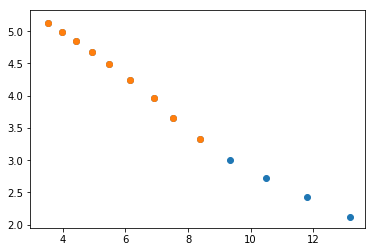

In [8]:
plt.scatter(np.sqrt(energy[0,fa:mb]),np.log10(yall_90))
plt.scatter(np.sqrt(energy[0,ma:mb]),np.log10(yt_90))

[4.8719449e+00 2.9216034e+01 1.4843472e+02 5.7379565e+02 1.6882080e+03
 4.2497173e+03 7.9333848e+03 1.6873998e+04 3.0388771e+04 4.8365898e+04
 7.2094375e+04 9.9598938e+04 1.3149439e+05]
[ 7.37806831e+12 -3.08765580e+01  5.42220992e+00]


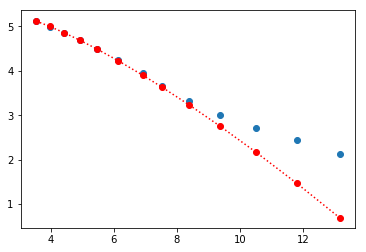

In [9]:
# simple Maxwell fit

x = np.sqrt((energy[0,ma:mb]))
xall = np.sqrt((energy[0,fa:mb]))
y = (yt_90)
yall = (yall_90)

#the number of data

mean = sum(x * y) / sum(y)
sigma = 1

def maxwell(x,a,x0,sigma):
    return a*np.sqrt(2/np.pi)*(x**2)*np.exp(-(x-x0)**2/(2*(sigma**2)))
    #return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(maxwell,x,y,p0=[np.max(y),mean,sigma],maxfev=10000)

plt.scatter(xall,np.log10(yall),label='averaged data')
plt.plot(xall,np.log10(maxwell(xall,*popt)),'ro:',label='fit')
print(maxwell(xall,*popt))
print(popt)

[2.0539263e-01 3.4839928e+00 3.8912754e+01 2.5588383e+02 1.0536125e+03
 3.3080718e+03 6.9116641e+03 1.6162284e+04 3.0347926e+04 4.8948996e+04
 7.2869359e+04 9.9889727e+04 1.3076914e+05]
[6.00668768e+00 2.89445297e+04 4.94709854e-03]


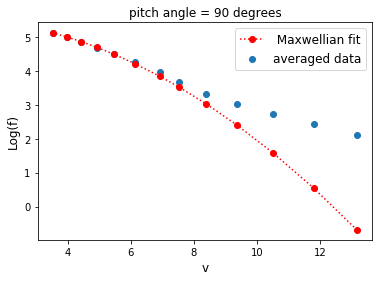

In [14]:
# Stverak 2008 core Maxwellian fit

x = np.sqrt((energy[0,ma:mb]))
xall = np.sqrt((energy[0,fa:mb]))
y = (yt_90)
yall = (yall_90)

#the number of data
m = 1
k = 1

n_scale = np.max(y)
T_scale = 1
T_func = 1

def maxwellian(x,T_c,n_c,T_f):
    return n_c*(1/T_f)*((m/(2*np.pi*k))**(3/2))*np.exp(-m*((x)**2)/(2*k*T_c))

popt,pcov = curve_fit(maxwellian,x,y,p0=[T_scale,n_scale,T_func],maxfev=10000)

plt.scatter(xall,np.log10(yall),label='averaged data')
plt.plot(xall,np.log10(maxwellian(xall,*popt)),'ro:',label=' Maxwellian fit')
plt.title("pitch angle = 90 degrees")
plt.xlabel("v",fontsize=12)
plt.ylabel("Log(f)",fontsize=12)
plt.legend(fontsize=12)
print(maxwellian(xall,*popt))
print(popt)